In [2]:
# set path
import os
import sys
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

In [3]:
# load modules
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *

In [4]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [5]:
## Functions for data exploration and visualization

In [6]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [7]:
# https://peps.python.org/pep-0484/
def img_to_gif(filenames: list, gif_path: str):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images, fps=5)

In [8]:
import re

def camelize(string):
    output = ''.join(x for x in string.title() if x.isalnum())
    return output[0].lower() + output[1:]

def snakify(string):
    name=camelize(string)
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

print(snakify("Clinical Trial Site Count by Country: 2021"))

clinical_trial_site_count_by_country2021


In [36]:
def choropleth(df, year: int):

    sites_df=df[df.start_datetime.dt.year==year]['country_alpha_3'].value_counts().reset_index()
    sites_df.columns=['country','values']

    # df = px.data.gapminder().query("year==2007")
    fig = px.choropleth(sites_df, locations="country",
                        color=np.log10(sites_df["values"]), 
                        hover_name="country",
                        color_continuous_scale='Reds')

    # log https://community.plotly.com/t/how-to-make-a-logarithmic-color-scale-in-my-choropleth-map/35010/4
    fig.update_layout(coloraxis_colorbar=dict(len=0.75,
                      title='# of Trial-Sites', 
                      tickvals = [0, 1, 2, 3, 3.699, 4],
                      ticktext = ['1', '10', '100', '1000', '5000','10000'],                                  

    ),
                                              legend=dict(yanchor='middle', xanchor='right', x=3
        # bbox_to_anchor=(0.6,0.5)
        )   
                     
                     )
    
    title="Clinical Trial Site Count by Country: "+str(year)
    
    fig.update_layout(
        title={
            'text' : title,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'bottom'
        }
        # geo_scope='usa', # limite map scope to USA
    )
    

    
    filename=snakify(title)+".png"
    
    filepath="./visuals/"+filename
    fig.write_image(filepath)

    # log transform colors
    # fig.update_geos(fitbounds="locations", visible=False)
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.show()

    iplot(fig,validate=False, filename=filepath)
    
    return filepath
    # plot(fig, validate=False, filename='d3-world-map.html', image='png')

In [29]:
def get_country_alpha_2(country_name):
    manual_map={'Taiwan':'TW',
               'Czech Republic':'CZ',
               'Vietnam':'VN',
               'Venezuela':'VE',
                'Tanzania':'TZ',
                'Macedonia':'MK',
                'Former Serbia and Montenegro':'CS',
                'Palestinian Territory, occupied':'PS',
                'Swaziland':'SZ',
                'Yugoslavia':'YU',
                'Bolivia':'BO',
                'Kosovo':'XK',
                'Virgin Islands (U.S.)':'VI'
               }
    try:
        alpha_2=pc.countries.get(name=country_name).alpha_2
    except:
        alpha_2=manual_map.get(country_name, 'Null')

    
    return alpha_2

def get_country_alpha_3(country_name):
    manual_map={'Taiwan':'TWN',
               'Czech Republic':'CZE',
               'Vietnam':'VNM',
               'Venezuela':'VEN',
                'Tanzania':'TZA',
                'Macedonia':'MKD',
                'Macedonia, The Former Yugoslav Republic of':'MKD',
                'Former Serbia and Montenegro':'SCG',
                'Palestinian Territory, occupied':'PSE',
                'Swaziland':'SWZ',
                'Yugoslavia':'YUG',
                'Former Yugoslavia':'YUG',
                'Bolivia':'BOL',
                'Kosovo':'XKX',
                'Virgin Islands (U.S.)':'VIR'
               }
    try:
        alpha_3=pc.countries.get(name=country_name).alpha_3
    except:
        alpha_3=manual_map.get(country_name, 'Null')

    
    return alpha_3

In [31]:
# Get cancer trial sites
# trial_sites=aq.query_aact(aq.get_cancer_trial_sites())
trial_sites=pd.read_csv(path+"/extract/extracted_data/cancer_trials_sites.csv", index_col=0)

In [32]:
# Clean site data
ctgov_data_prep(trial_sites)
trial_sites['facility_country'].fillna('Null', inplace=True)
trial_sites['country_alpha_2']=trial_sites.facility_country.apply(lambda x: get_country_alpha_2(x))
trial_sites['country_alpha_3']=trial_sites.facility_country.apply(lambda x: get_country_alpha_3(x))

In [33]:
trial_sites[trial_sites['country_alpha_3']=='Null'].facility_country.value_counts()

Null    4443
Name: facility_country, dtype: int64

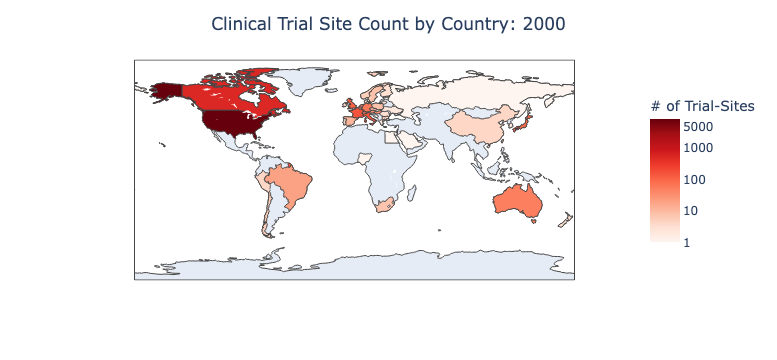

'./visuals/clinical_trial_site_count_by_country2000.png'

In [40]:
choropleth(trial_sites, 2000)

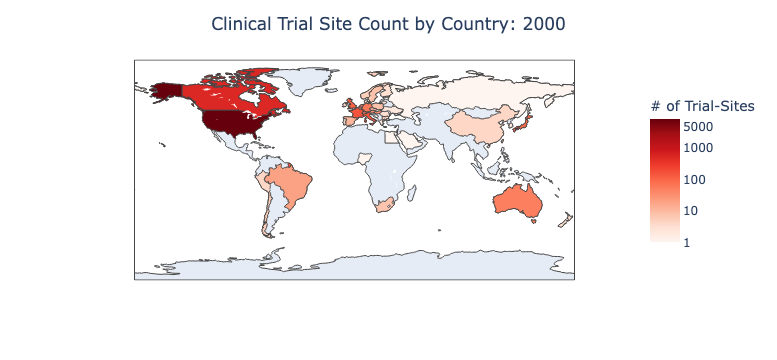

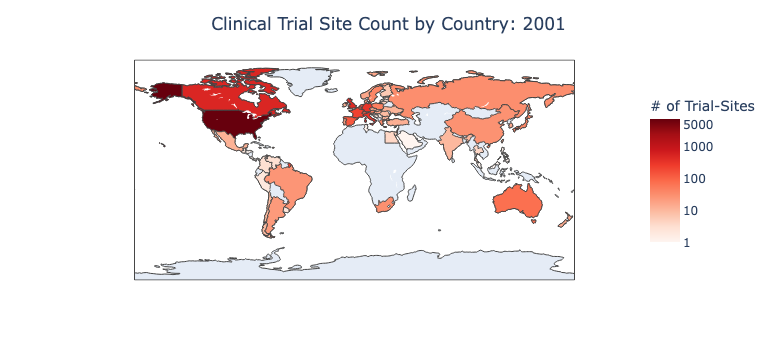

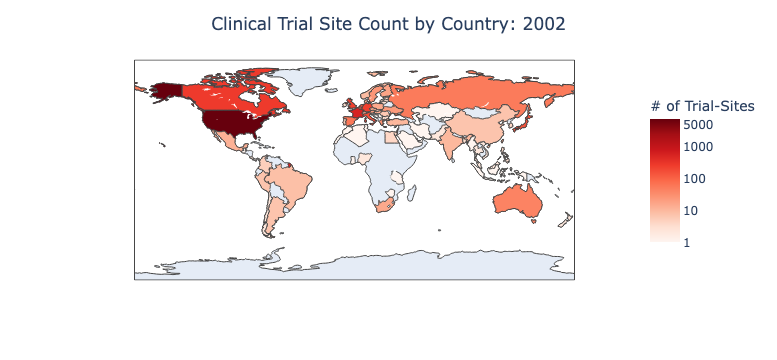

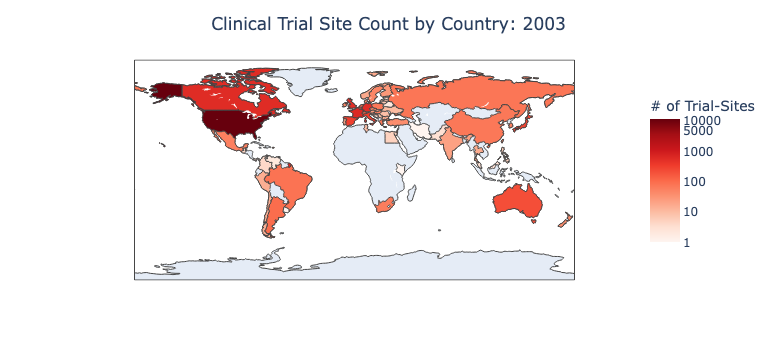

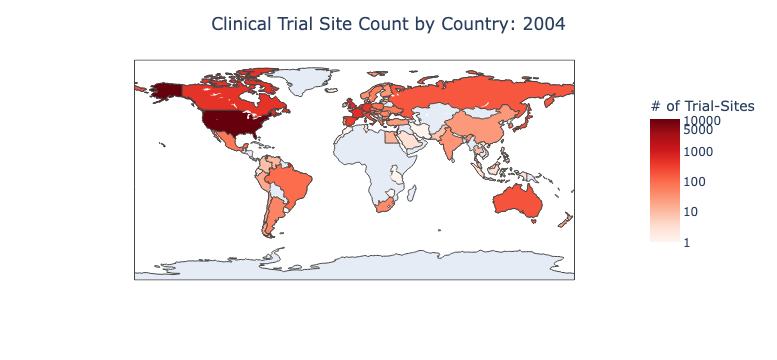

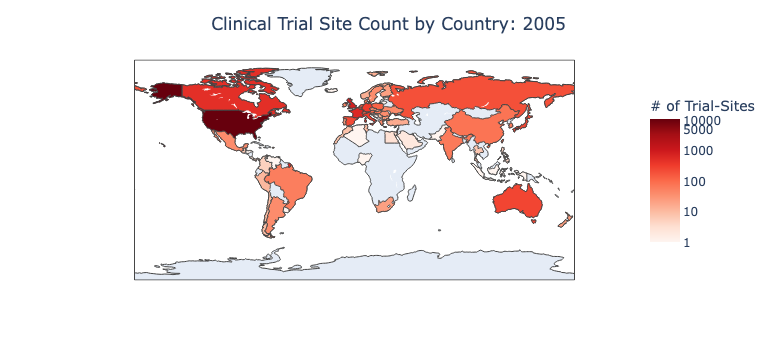

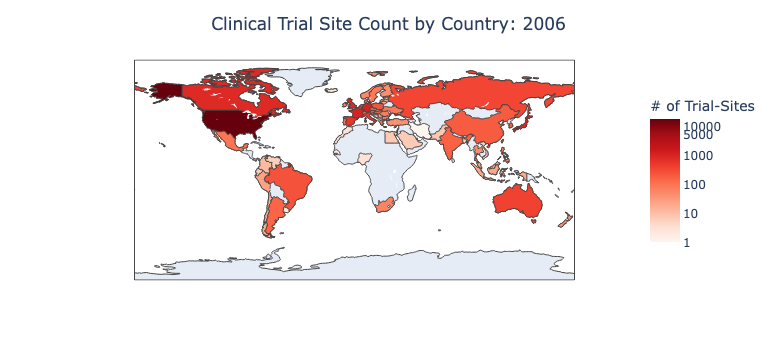

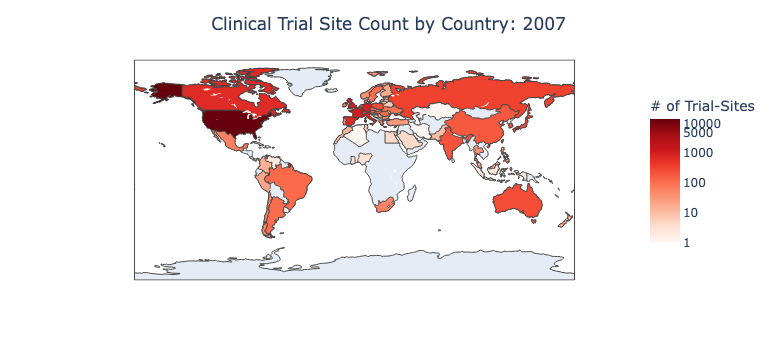

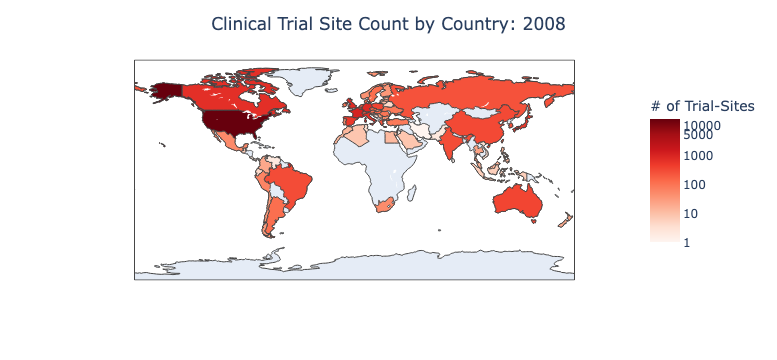

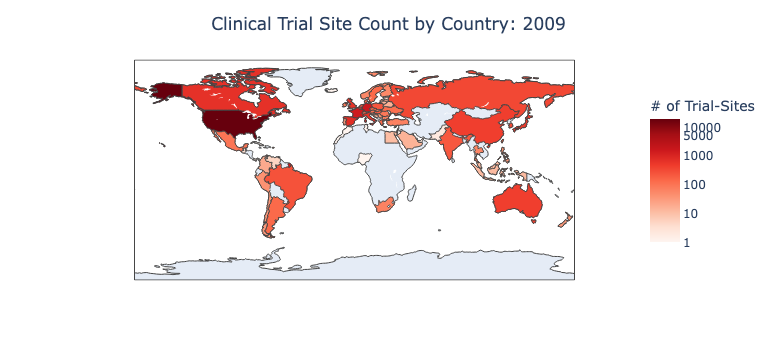

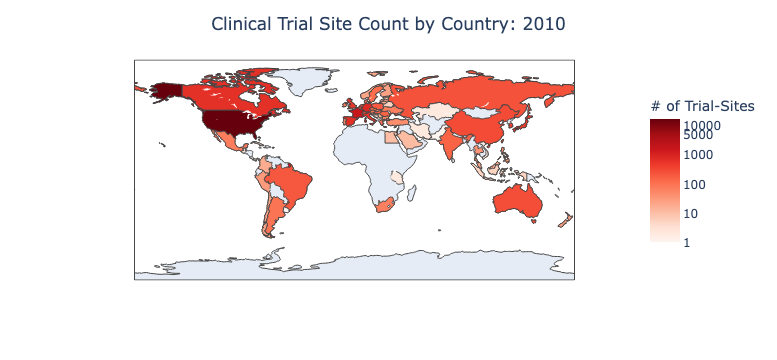

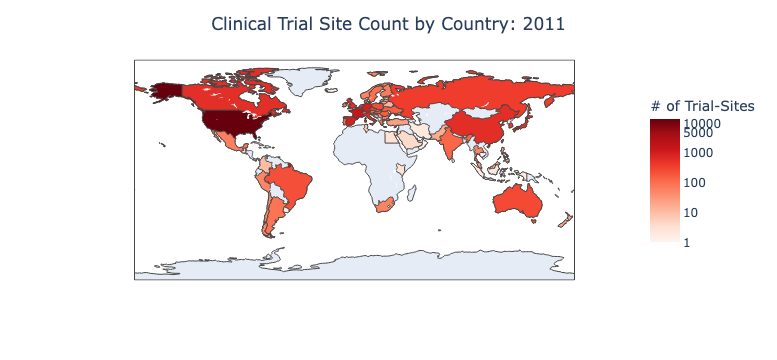

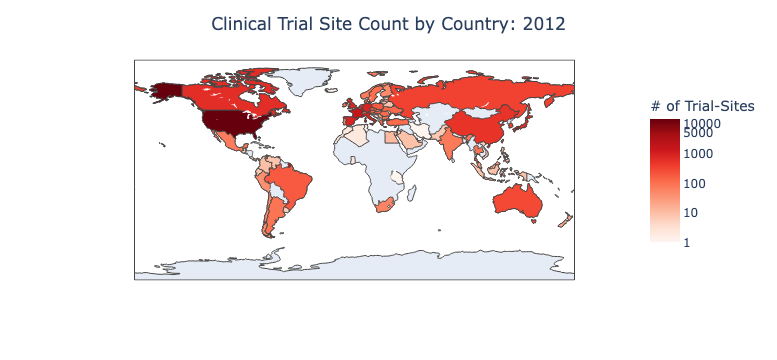

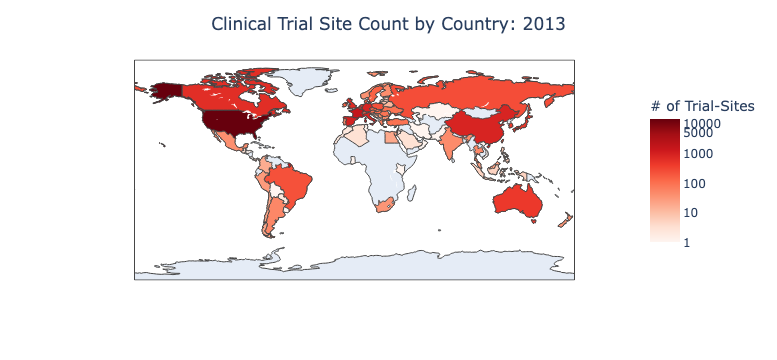

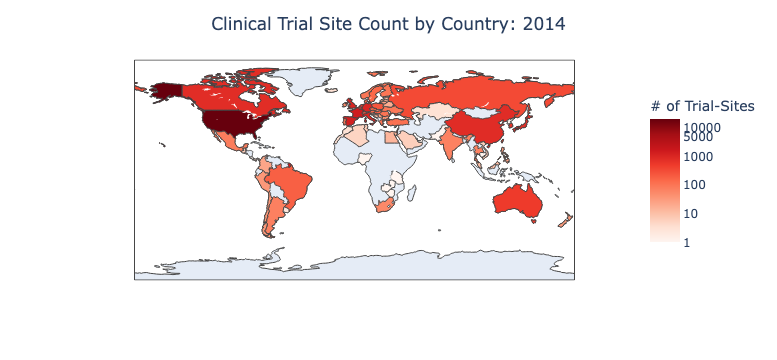

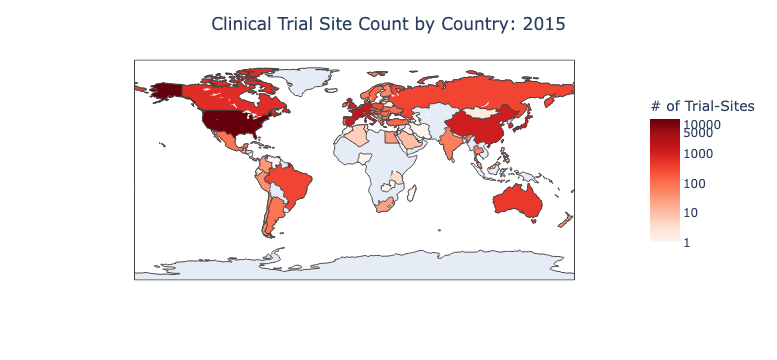

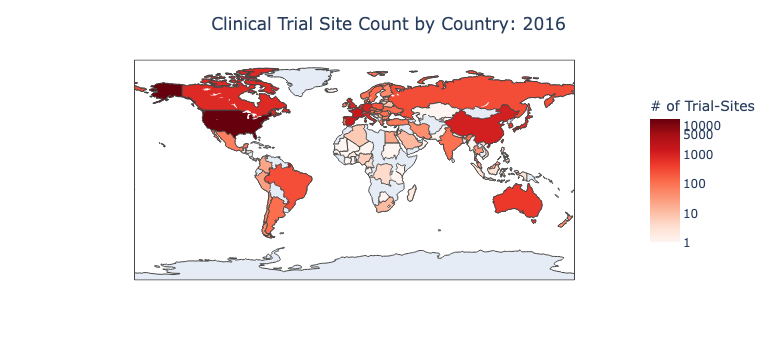

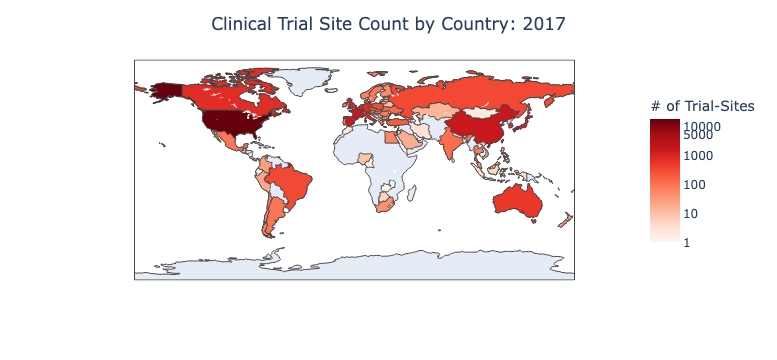

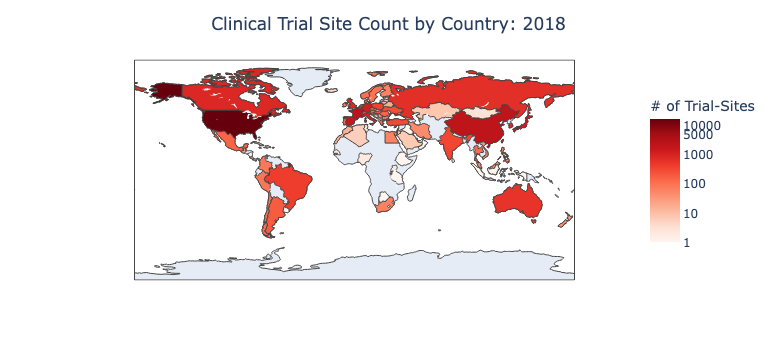

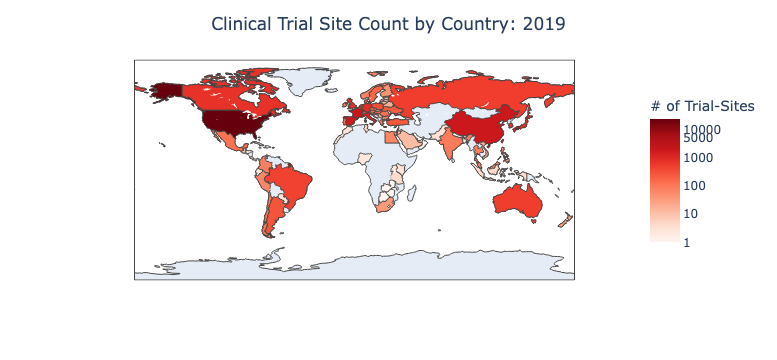

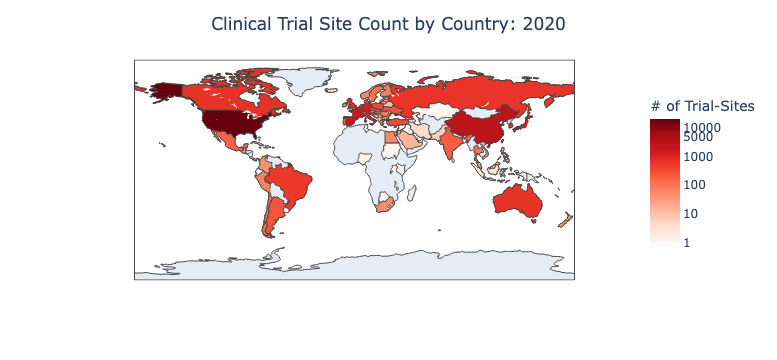

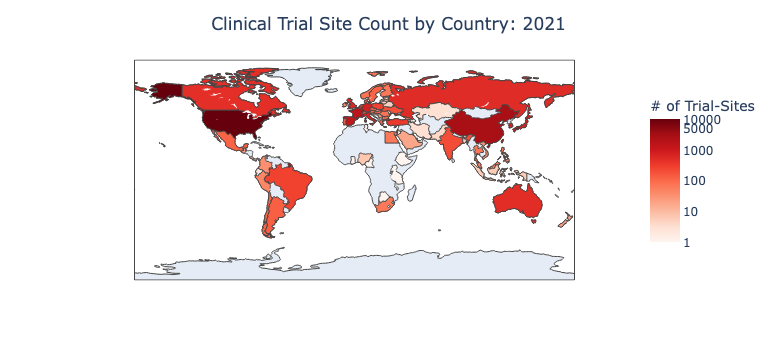

In [38]:
# Create trial site volume map by year
filenames=[]

for x in range(2000,2022):
    filenames.append(choropleth(trial_sites, x))

In [39]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')